### 진행 순서

- 데이터셋 **로드, 전처리** -> **토큰화** 하기 -> 트랜스포머's **모델 로드**, **훈련**, **추론** -> **모델 평가**
- 🤗데이터셋, 🤗토크나이저, 🤗트랜스포머 라이브러리 이용


### 데이터셋

[🤗데이터셋 docs🤗](https://huggingface.co/docs/datasets/index)

```py
load_dataset("파일 형식(csv,text,json 등..)", data_files="경로")

# ex 예시
load_dataset(
    "csv",
    data_files="file.csv",
    sep=";",
    name=["text","label"])
```

In [2]:
from datasets import load_dataset

dataset = load_dataset("emotion")

In [3]:
dataset # 아파치 애로우 형식 : 하나의 행이 하나의 딕셔너리

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

> 아파치 애로우 형식: 시스템과 프로그래밍 언어 간에 데이터를 효율적으로 교환할 수 있는 컬럼형 인메모리 데이터 형식

In [4]:
dataset['train']['text'][0]

'i didnt feel humiliated'

In [5]:
train_data = dataset['train']

In [6]:
len(train_data), 

(16000,)

### 데이터 셋 to Dataframe

In [7]:
import pandas as pd 

train_data.set_format(type="pandas")
df = train_data[:]

In [8]:
df['label_name'] = df['label'].apply(lambda x: train_data.features["label"].int2str(x))

In [9]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


### **데이터 클래스 분포 확인**

- 데이터 불균형 샘플링 기법
    - [📝내용 설명📝](https://github.com/tommyjin2894/ai_study?tab=readme-ov-file#%EC%83%98%ED%94%8C%EB%A7%81-%EA%B8%B0%EB%B2%95)
    - [🖥️상세 코드🖥️](https://github.com/tommyjin2894/ai_study/blob/main/code/00_basics/09_%EC%83%98%ED%94%8C%EB%A7%81.ipynb) 


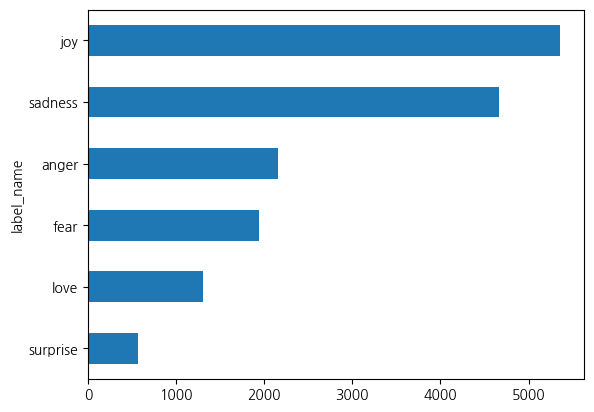

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh();

In [11]:
X = df.drop(columns=["label","label_name"])
y = df["label"]


In [12]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

ros = RandomOverSampler(random_state=42)
rus = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(train_x, train_y)
x_rous, y_rous = ros.fit_resample(x_ros, y_ros)

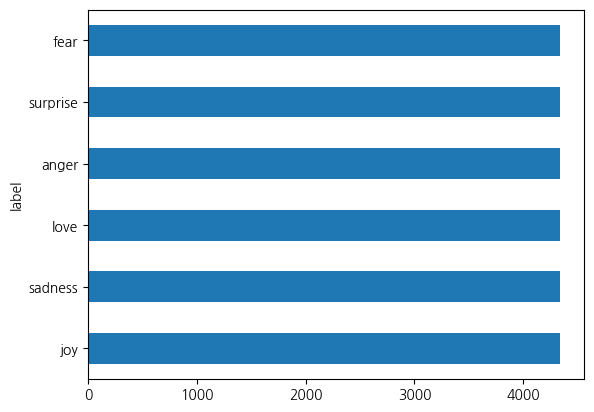

In [14]:
y_rous.apply(lambda x: train_data.features["label"].int2str(x))\
    .value_counts(ascending=True).plot.barh();

### 문장 길이 확인(최대 토큰 길이 측정)
- 간단하게 단어 기준으로 토큰화 진행

In [15]:
df["label_name"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [16]:
df['token_length'] = df['text'].str.split(" ").apply(lambda x:len(x))

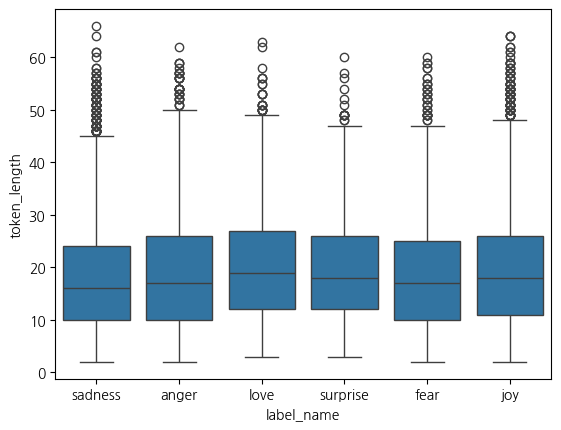

In [17]:
import seaborn as sns

sns.boxplot(data=df,
            x='label_name',
            y='token_length');

### 문장 토큰화 하기

In [18]:
words = set([word for sen in df['text'] for word in sen.split(" ")])
words = sorted(words)
words[1000:2000:100]

['bag',
 'battalion',
 'believers',
 'bikini',
 'blissed',
 'bombsite',
 'braided',
 'bruise',
 'bus',
 'canning']

In [19]:
token2idx = {ch: idx for ch, idx in enumerate(words)}
for i in range(1,16001,1001):
    print(f"index:{i:05}",token2idx[i])

index:00001 aa
index:01002 bagel
index:02003 castiel
index:03004 creates
index:04005 drew
index:05006 figured
index:06007 harder
index:07008 irresponcible
index:08009 machinery
index:09010 nobu
index:10011 plea
index:11012 reminisced
index:12013 shuts
index:13014 sumthg
index:14015 ugg
index:15016 worsen


- 참고) 원핫 인코딩 - to sparse 하다

In [20]:
import torch
import torch.nn.functional as F


for_ohi = torch.tensor(list(token2idx.keys()))

In [21]:
don_ohi = F.one_hot(for_ohi)
don_ohi

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

### 부분 단어 토큰화
- 단어 토큰화(5 : "hello", ...) + 문자 토큰화(5 : "h", ...)

- 모델에 맞는 토큰화 방법

In [22]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer_method = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer_method_1 = DistilBertTokenizer.from_pretrained(model_ckpt)

In [23]:
text_str = "Trolling is pretty annoying"

In [24]:
at_token = tokenizer_method(text_str)['input_ids']
print(at_token)

[101, 18792, 2075, 2003, 3492, 15703, 102]


In [25]:
reversed_token = tokenizer_method.convert_ids_to_tokens(at_token)
print(f'{reversed_token}')

['[CLS]', 'troll', '##ing', 'is', 'pretty', 'annoying', '[SEP]']


- [CLS] 문장의 시작,
- [sep] 문장의 분리를 의미,
- `##` 앞 문자열의 공간이 비어있지 않음

In [26]:
tokenizer_method.convert_tokens_to_string(reversed_token)

'[CLS] trolling is pretty annoying [SEP]'

- vocab 크기 확인

In [27]:
print('모델의 vocab 사이즈 :',tokenizer_method.vocab_size)
print('모델의 최대 길이 :',tokenizer_method.model_max_length)
print('모델의 필드 이름 :',tokenizer_method.model_input_names)

모델의 vocab 사이즈 : 30522
모델의 최대 길이 : 512
모델의 필드 이름 : ['input_ids', 'attention_mask']


### 전체 데이터 셋 토큰화

In [28]:
for i in dataset['train'][:3]['text']:
    print(i)

i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
im grabbing a minute to post i feel greedy wrong


In [29]:
tokenize = lambda batch : tokenizer_method([exam for exam in batch['text']],
                                           padding=True, truncation=True)
# test
tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [30]:
# all from datasets

all_datasets_toknized = dataset.map(tokenize, batched=True, batch_size=None)

In [31]:
all_datasets_toknized['train'][:2]

,input_ids,attention_mask
0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### DistilBERT 훈련하기

- transformers 는 tensorflow, Jax 에서 훈련된 사전 훈련 모델 사용이 가능하다.
    
    ```python
    from transformers import TFAutoModel
    tf_model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True)
    ```
    - Tensorflow의 모델을 불러와 자동으로 변환한다.


In [32]:
model_ckpt

'distilbert-base-uncased'

In [33]:
from transformers import AutoModel

device = torch.device("cuda")
model = AutoModel.from_pretrained(model_ckpt).to(device)

2024-11-15 18:12:38.554314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731661958.589741   90904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731661958.600061   90904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 18:12:38.646701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
text = "test is fun!"
inputs = tokenizer_method(text, return_tensors='pt') # return_tensors = 옵션 ['pt', 'tf', 'np', 'jax', 'mlx']
inputs={k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 101, 3231, 2003, 4569,  999,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

- 필요한 인자 넘겨주기 `input_ids`, `attention_mask`

In [35]:
with torch.no_grad():
    outputs=model(**inputs)

outputs #named tuple 형태

BaseModelOutput(last_hidden_state=tensor([[[-3.2901e-02, -1.5536e-01,  6.7294e-02,  ..., -3.5374e-02,
           2.2140e-01,  3.0278e-01],
         [ 5.3307e-01, -1.2262e-01,  4.2616e-04,  ..., -3.5551e-01,
           3.7947e-01, -4.7466e-01],
         [-3.0976e-01, -1.6439e-01,  4.3289e-02,  ..., -1.1604e-01,
           1.2671e-01,  4.7686e-01],
         [-9.3830e-03, -1.9277e-01,  2.1580e-01,  ..., -1.1667e-01,
           8.4669e-02,  7.3999e-02],
         [-9.4883e-02, -4.1041e-01,  1.4524e-01,  ...,  2.6162e-01,
           2.6452e-01, -1.3557e-01],
         [ 9.4918e-01,  2.1852e-01, -3.9139e-01,  ...,  2.4219e-01,
          -4.7567e-01, -3.0236e-01]]], device='cuda:0'), hidden_states=None, attentions=None)

- [distilBERT](https://arxiv.org/pdf/1910.01108) 란?
    - BERT 대비 40% 작은 모델
    - 언어 이해 능력의 97% 유지
    - 60% 빠른 속도
    - triple loss method:
        - loss combining language modeling,
        - distillation
        - cosine-distance losses
        
    - 참고
        - [Knowledge Distilling](https://arxiv.org/pdf/1503.02531)
        - Task-specific distillation
        - [Multi-distillation](https://arxiv.org/pdf/2210.16103)

In [36]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

- 1 배치, 6 토큰, 768 차원의 임베딩 벡터

In [37]:
#각 6개의 토큰마다 768 차원의 임베딩 벡터
tokenizer_method.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]', 'test', 'is', 'fun', '!', '[SEP]']

### DistilBERT 예측 분류(machine learning head)

- 데이터셋 불러오기

In [38]:
from datasets import load_dataset

dataset = load_dataset("emotion")

- 모델 및 토크나이저 불러오기

In [39]:
from transformers import AutoTokenizer
from transformers import AutoModel
import torch

device = torch.device("cuda")

model_ckpt="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [40]:
tokenize = lambda batch : tokenizer([exam for exam in batch['text']],
                                           padding=True, truncation=True)

In [41]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

- hidden_state 추출

In [42]:
def extract_hs(batch):
    inputs= {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        lst_hs = model(**inputs).last_hidden_state
    print(lst_hs)
    return {'hidden_state': lst_hs[:,0].cpu().numpy()}

In [43]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [44]:
emotion_hiddenstate = dataset_encoded.map(extract_hs, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

tensor([[[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
         [ 0.1325,  0.1516, -0.1169,  ..., -0.1119,  0.5562,  0.2908],
         [-0.1053,  0.2862,  0.1958,  ...,  0.0241,  0.0577, -0.3627],
         ...,
         [-0.1576,  0.0898, -0.0468,  ...,  0.0662, -0.0555, -0.3040],
         [-0.1641,  0.0944, -0.0331,  ...,  0.0501, -0.0445, -0.3198],
         [-0.2448,  0.1373,  0.3082,  ..., -0.0214,  0.1674, -0.1861]],

        [[-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
         [ 0.2920,  0.2514, -0.3510,  ..., -0.0705,  0.4476,  0.3433],
         [ 0.1124,  0.2768, -0.1371,  ..., -0.3548,  0.6641,  0.0977],
         ...,
         [-0.0134,  0.1927, -0.1303,  ..., -0.0439,  0.1111, -0.1301],
         [-0.0230,  0.1415, -0.1237,  ...,  0.0382,  0.0511, -0.1063],
         [-0.0700,  0.0209, -0.0227,  ...,  0.0192,  0.0657, -0.1047]],

        [[ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
         [-0.1390,  0.4226,  0.8182,  ..., -0

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

tensor([[[-0.1344,  0.2183,  0.1235,  ..., -0.0053,  0.4089,  0.5558],
         [-0.3856,  0.5841,  0.8557,  ..., -0.1158,  0.3474,  0.8189],
         [-0.6706,  0.2642,  0.3804,  ...,  0.1742, -0.1075,  0.3054],
         ...,
         [-0.0192,  0.2574,  0.7946,  ..., -0.0606, -0.0300,  0.0772],
         [-0.3040,  0.3378,  0.4163,  ..., -0.0584, -0.0022, -0.1880],
         [-0.1114,  0.4629,  0.4237,  ..., -0.0445, -0.0657, -0.2780]],

        [[ 0.0801,  0.0826, -0.0419,  ...,  0.0544,  0.3219,  0.3625],
         [ 0.2590,  0.2980, -0.3295,  ...,  0.0975,  0.6726,  0.4906],
         [-0.3085,  0.4177,  0.3497,  ...,  0.0044,  0.1175,  0.6552],
         ...,
         [ 0.2877,  0.1912, -0.0093,  ..., -0.0049,  0.0910,  0.1408],
         [ 0.2511,  0.1843,  0.0122,  ...,  0.0458,  0.1013,  0.1536],
         [ 0.3906,  0.3358, -0.0083,  ...,  0.0643,  0.3086,  0.0023]],

        [[ 0.0147,  0.1749,  0.0430,  ...,  0.0880,  0.3221,  0.2580],
         [ 0.3866,  0.3713, -0.0738,  ...,  0

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

tensor([[[-0.0216,  0.1965,  0.0041,  ..., -0.0646,  0.4319,  0.5599],
         [-0.4236,  0.4446,  0.6385,  ..., -0.1813,  0.5174,  0.8447],
         [-0.3232, -0.1305,  0.0817,  ..., -0.1333, -0.0079,  0.1213],
         ...,
         [ 0.0801, -0.0661, -0.0128,  ..., -0.3176, -0.1904,  0.0036],
         [ 0.2277, -0.0867, -0.0559,  ..., -0.2281, -0.2148, -0.3028],
         [ 0.2139, -0.0760, -0.0265,  ..., -0.1154, -0.2775, -0.2979]],

        [[-0.0165,  0.3204, -0.0225,  ..., -0.1050,  0.4260,  0.4670],
         [-0.1441,  0.5567,  0.5354,  ...,  0.0413,  0.4918,  0.9446],
         [-0.1491,  0.0316,  0.2680,  ...,  0.1760,  0.3562, -0.1429],
         ...,
         [-0.0496,  0.1777,  0.3578,  ..., -0.1996,  0.0088,  0.1758],
         [ 0.1533,  0.1583,  0.1210,  ...,  0.1017,  0.0015, -0.2292],
         [ 0.1613,  0.1854,  0.1490,  ...,  0.1085,  0.0087, -0.2382]],

        [[-0.1114,  0.0211, -0.2773,  ..., -0.0317,  0.2478,  0.2088],
         [ 0.3072,  0.6437, -0.4697,  ...,  0

In [45]:
emotion_hiddenstate

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

- 특성 행렬 만들기

In [46]:
import numpy as np

x_train = np.array(emotion_hiddenstate['train']['hidden_state'])
x_valid = np.array(emotion_hiddenstate['validation']['hidden_state'])
y_train = np.array(emotion_hiddenstate['train']['label'])
y_valid = np.array(emotion_hiddenstate['validation']['label'])

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((16000, 768), (16000,), (2000, 768), (2000,))

In [47]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

x_scaled = MinMaxScaler().fit_transform(x_train)

mapper = UMAP(n_components=2, metric="cosine").fit(x_scaled)

In [48]:
import pandas as pd

df_emb = pd.DataFrame(mapper.embedding_, columns=["x","y"])
df_emb["label"] = y_train
df_emb.head(2)

,x,y,label
0,4.209736,7.861980,0
1,-2.975325,7.073868,0


- 라벨 별 시각화

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

cmaps = ["Greys","Blues","Oranges","Reds","Purples","Greens"]
mapping_cmaps = lambda x : cmaps[x]

df_emb['cmap']=df_emb['label'].map(mapping_cmaps)

In [50]:
labels = emotion_hiddenstate['train'].features['label'].names

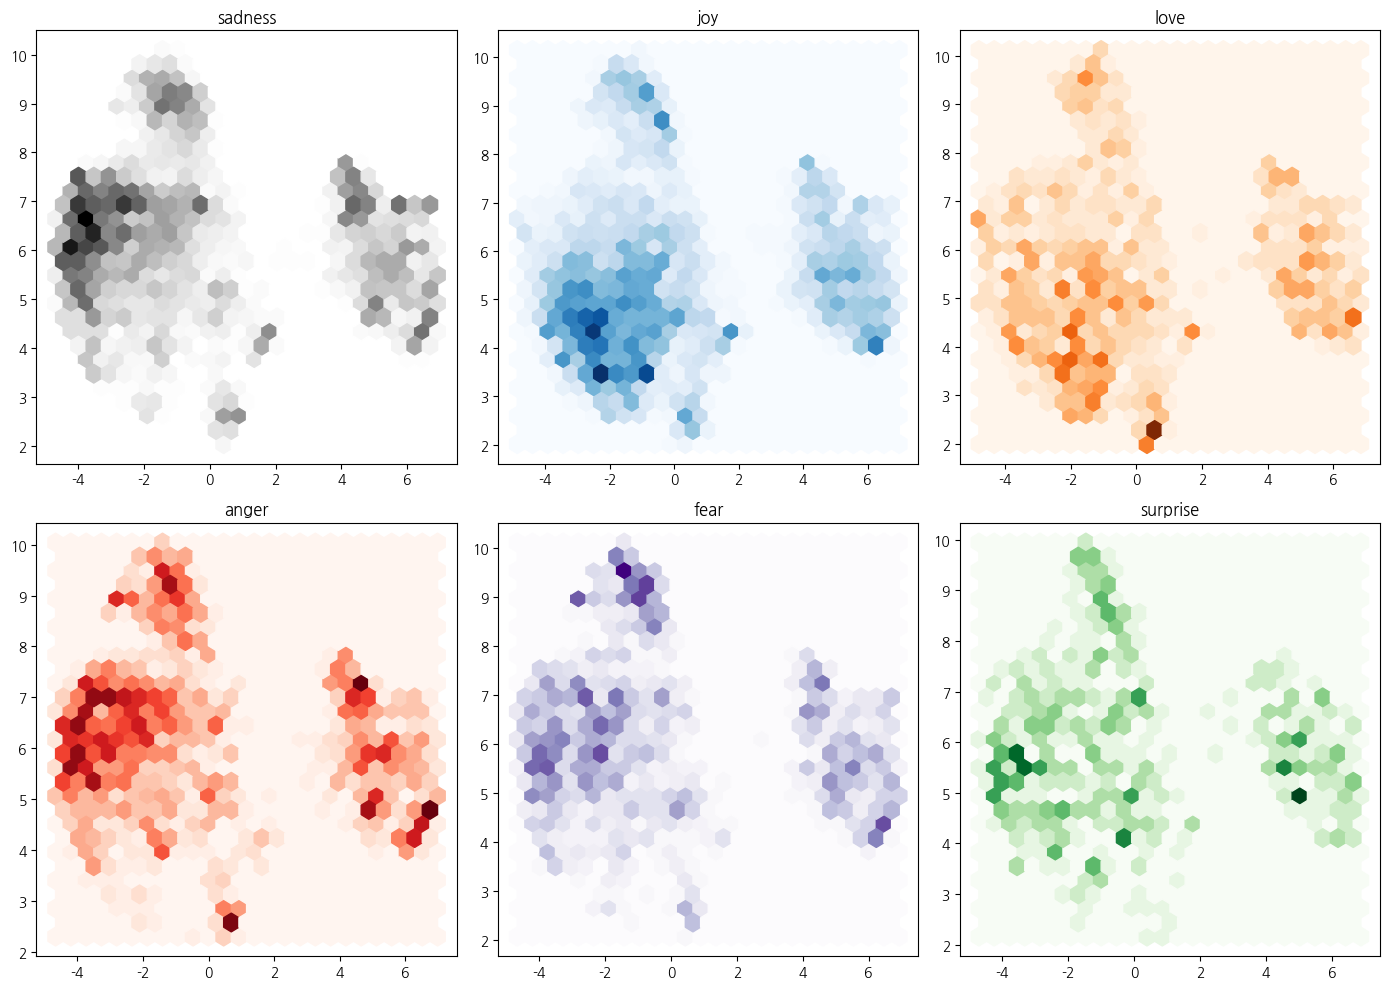

In [51]:
fig, ax = plt.subplots(2,3, figsize=(14,10))
ax = ax.flatten()

for i, ax_ in enumerate(ax):
    df_emb_choosen=df_emb[df_emb.label == i]
    ax_.hexbin(
        x=df_emb_choosen['x'],
        y=df_emb_choosen['y'],
        gridsize=25,
        cmap=cmaps[i]
        )
    ax_.set_title(labels[i])
plt.tight_layout()

- 분류시작

In [52]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform") # 무작위 일때 "uniform" : 0.165%, "most_frequent" : 0.352
dummy_clf.fit(x_train,y_train)
dummy_clf.score(x_valid,y_valid)

0.17

- confusion_mat 확인

In [53]:
from sklearn import metrics

print(metrics.classification_report(y_valid, dummy_clf.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.28      0.17      0.21       550
           1       0.33      0.17      0.22       704
           2       0.11      0.20      0.15       178
           3       0.14      0.16      0.15       275
           4       0.10      0.16      0.12       212
           5       0.05      0.20      0.08        81

    accuracy                           0.17      2000
   macro avg       0.17      0.18      0.16      2000
weighted avg       0.24      0.17      0.19      2000



- 시각화 후 확인

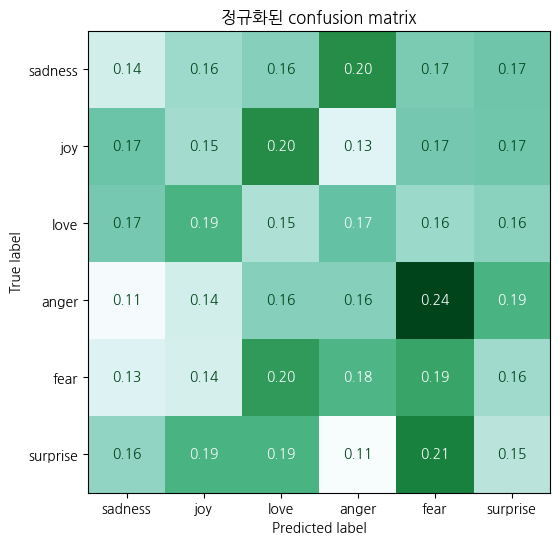

In [54]:
# 시각화 함수 정의
def plot_confusion_mat(y_preds,y_true,labels):
    cm = metrics.confusion_matrix(y_true,y_preds,normalize="true") # 정규화된 오차 행렬
    fig, ax = plt.subplots(figsize=(6,6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuGn",
              values_format=".2f",
              colorbar=False,
              ax=ax)
    plt.title("정규화된 confusion matrix")
    return 


plot_confusion_mat(dummy_clf.predict(x_valid), y_valid, labels)

### distilBERT(End to End finetuning)
- 이때 head 부분은 미분이 가능해야함

In [55]:
from transformers import AutoModelForSequenceClassification # AutoModel와 달리 분류 헤드가 장착되어 있다.

num_labels=6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- metric 정의

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels,preds)
    return {"accuracy" : acc, "f1" : f1} # 훈련 시 출력 형식 맞추기

- git 로그인

In [57]:
from huggingface_hub import notebook_login

notebook_login()

logging_steps = len(emotion_hiddenstate)

In [60]:
!pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.2 MB/s eta 0:00:00a 0:00:01


In [61]:
from transformers import TrainingArguments
batchsize = 64

log_step = len(emotion_hiddenstate['train'])//batchsize
model_name=f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batchsize,
                                  per_device_train_batch_size=batchsize,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=log_step,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [62]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_hiddenstate["train"],
                  eval_dataset = emotion_hiddenstate["validation"],
                  tokenizer=tokenizer)

trainer.train()

/tmp/ipykernel_90904/3502619010.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.816700,0.308063,0.906500,0.905929
2,0.249300,0.214537,0.925000,0.925268


TrainOutput(global_step=500, training_loss=0.5329788131713867, metrics={'train_runtime': 196.7614, 'train_samples_per_second': 162.634, 'train_steps_per_second': 2.541, 'total_flos': 720342861696000.0, 'train_loss': 0.5329788131713867, 'epoch': 2.0})

- metrics 확인

In [63]:
pred_out = trainer.predict(emotion_hiddenstate['validation'])
pred_out.metrics

{'test_loss': 0.2145373523235321,
 'test_accuracy': 0.925,
 'test_f1': 0.9252679998539944,
 'test_runtime': 2.7098,
 'test_samples_per_second': 738.056,
 'test_steps_per_second': 11.809}

In [64]:
y_preds = np.argmax(pred_out.predictions, axis=1)
y_preds

array([0, 0, 2, ..., 1, 1, 1])

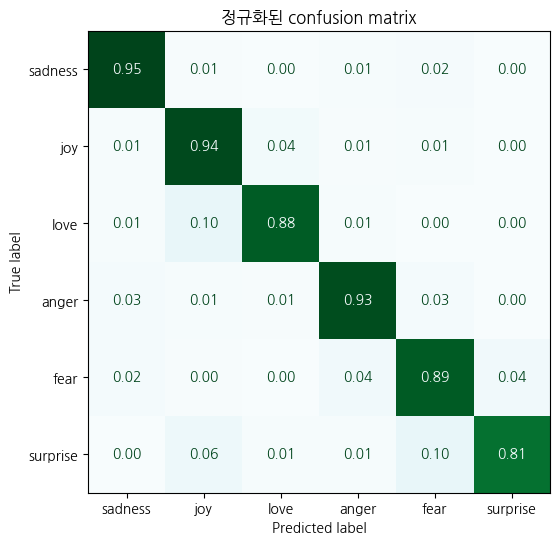

In [65]:
plot_confusion_mat(y_preds, y_valid, labels)

- 소요 리소스 확인
    ![resorce_check](images/02_01.png)

### cf) keras로 훈련 시키기(예시)
```py
from transformers import TFAutoModelForSequenceClassification

tf_model=TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

# 데이터 변환 to TF dataset

tokenizer_columns = tokenizer.model_input_names
tf_train = emotion_hiddenstate["train"].to_tf_dataset(
    columns = tokenizer_columns,
    label_cols= ['label'],
    shuffle=True,
    batch_size=batchsize
)

tf_valid = emotion_hiddenstate["validation"].to_tf_dataset(
    columns = tokenizer_columns,
    label_cols= ['label'],
    shuffle=False,
    batch_size=batchsize
)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy



opti_ = Adam(learning_rate=5e-5)
loss_ = SparseCategoricalCrossentropy(from_logits=True)
metr_ = SparseCategoricalAccuracy()

tf_model.compile(
    optimizer = opti_ ,
    loss = loss_ ,
    metrics = metr_ ,
)

tf_model.fit(tf_train, validation_data=tf_valid, epochs=2)
```